100%|██████████| 26421880/26421880 [00:01<00:00, 16019900.88it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275278.36it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4936643.26it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17655173.34it/s]


Streaming output truncated to the last 5000 lines.
Epoch [2/10], Step [41900/60000], Loss: 0.0002
Epoch [2/10], Step [42000/60000], Loss: 0.5638
Epoch [2/10], Step [42100/60000], Loss: 0.0334
Epoch [2/10], Step [42200/60000], Loss: 0.0000
Epoch [2/10], Step [42300/60000], Loss: 0.0002
Epoch [2/10], Step [42400/60000], Loss: 0.0758
Epoch [2/10], Step [42500/60000], Loss: 1.6645
Epoch [2/10], Step [42600/60000], Loss: 0.0048
Epoch [2/10], Step [42700/60000], Loss: 0.0000
Epoch [2/10], Step [42800/60000], Loss: 0.0010
Epoch [2/10], Step [42900/60000], Loss: 0.0214
Epoch [2/10], Step [43000/60000], Loss: 1.5798
Epoch [2/10], Step [43100/60000], Loss: 0.0041
Epoch [2/10], Step [43200/60000], Loss: 0.0398
Epoch [2/10], Step [43300/60000], Loss: 0.0001
Epoch [2/10], Step [43400/60000], Loss: 0.2314
Epoch [2/10], Step [43500/60000], Loss: 3.3968
Epoch [2/10], Step [43600/60000], Loss: 0.0348
Epoch [2/10], Step [43700/60000], Loss: 0.0000
Epoch [2/10], Step [43800/60000], Loss: 0.1815
Epoch [2/

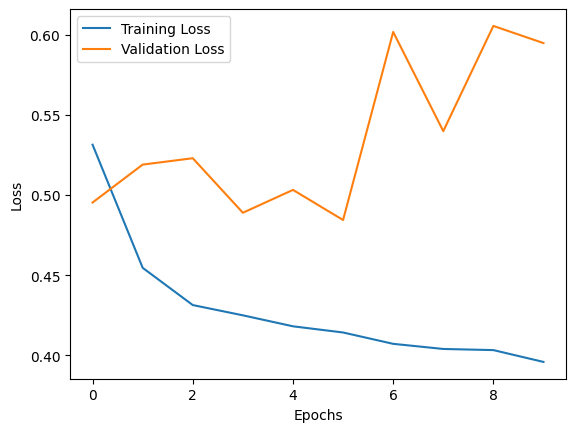

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10
sequence_length = 100

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Define your SNN model
snn_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)

# Lists to store the training and validation loss
train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    running_loss = 0.0  # Initialize running loss

    for i, (images, labels) in enumerate(train_loader):
        # Reset the state of the SNN for each sequence
        snn_model.zero_grad()

        # Forward pass (FPTT)
        for t in range(sequence_length):
            # Flatten the input image
            images = images.view(-1, 784)

            # Forward pass through the SNN
            spikes = snn_model(images)

        # Compute loss and perform backpropagation
        loss = criterion(spikes, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(spikes.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f'Training Loss after Epoch {epoch + 1}: {train_loss:.4f}')

    # Validation loop
    snn_model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 784)
            spikes = snn_model(images)
            loss = criterion(spikes, labels)
            validation_loss += loss.item()

            _, predicted = torch.max(spikes.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()

    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)

    print(f'Validation Loss after Epoch {epoch + 1}: {validation_loss:.4f}')

# Plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model to a file
torch.save(snn_model.state_dict(), 'my_snn_model2.pth')
